In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import const
from subprocess import check_output
from types import SimpleNamespace
from helper import *


In [96]:
sim = 'weak'

# get paths
base_path = os.path.join('..', 'rprocess', sim)
ab_path   = os.path.join(base_path, 'ab')
spec_path = os.path.join(base_path, 'betaspec')


In [97]:
# get line numbers for each timestep
idx_line_newstep_list = np.array(check_output(["awk", "/timestep/{ print NR }", ab_path]).decode("utf-8").split('\n'))[:-1].astype(int)
nstep = idx_line_newstep_list.size

# create arrays to store abundance data
step = np.zeros(nstep, dtype=int)
time = np.zeros(nstep)
rho = np.zeros(nstep)
temp = np.zeros(nstep)

Zmax = 118
ab_elem = np.zeros((nstep, Zmax+1))
A_avg   = np.zeros((nstep, Zmax+1))
ab_iso  = np.empty((nstep, Zmax+1), dtype=object)

for i in range(nstep):
    for Z in range(Zmax+1):
        ab_iso[i, Z] = [], []

# read abundance data
with open(ab_path, 'r') as f: lines = f.readlines()

for i in range(nstep):
    
    idx_line_info = idx_line_newstep_list[i]-1
    line_info_split = lines[idx_line_info].split()
    
    step[i] = int(line_info_split[1])
    time[i] = float(line_info_split[3]) * const.day
    rho[i] = float(line_info_split[7])
    temp[i] = float(line_info_split[5]) * 1e9
    
    idx_line_min = idx_line_newstep_list[i]
    idx_line_max = idx_line_newstep_list[i+1]-2 if i < nstep-1 else -1
    lines_data = lines[idx_line_min:idx_line_max]

    for line in lines_data:
    
        line_split = line.split()
        Z = int(line_split[0])
        A = int(line_split[1])
        ab = float(line_split[2])

        ab_iso[i, Z][0].append(A)
        ab_iso[i, Z][1].append(ab)
        ab_elem[i, Z] += ab
        A_avg[i, Z]   += A*ab
        
    for Z in range(Zmax+1):
        if A_avg[i, Z] > 0: A_avg[i, Z] /= ab_elem[i, Z]


In [98]:
# get file list
file_list = np.array([filename for filename in os.listdir(spec_path) if filename != 'meta.dat'])
idx_sorted = np.argsort([int(filename.split('_')[2][1:]) for filename in file_list])
file_list = file_list[idx_sorted]


In [99]:
# create energy array
with open(os.path.join(spec_path, file_list[0]), 'r') as f: lines = f.readlines()
ener = []
for j, line in enumerate(lines[1:-1]):
    ener.append(float(line.split()[0]) * 1e6)
ener = np.array(ener)
nstep = step.size
nener = ener.size

# create arrays to store spectrum data
beta_spec = np.zeros((nstep, nener))
gam_spec  = np.zeros((nstep, nener))
nu_spec   = np.zeros((nstep, nener))

# read spectrum data
for i, filename in enumerate(file_list):
    
    filename = file_list[i]
    with open(os.path.join(spec_path, filename), 'r') as f: lines = f.readlines()

    for j, line in enumerate(lines[1:-1]):
    
        line_split = line.split()
        beta_spec[i, j] = float(line_split[1]) / 1e6
        gam_spec[i, j]  = float(line_split[2]) / 1e6
        nu_spec[i, j]   = float(line_split[3]) / 1e6
    

In [100]:
np.savez(base_path, step=step, time=time, rho=rho, temp=temp, ab_elem=ab_elem, ab_iso=ab_iso, A_avg=A_avg, ener=ener, beta_spec=beta_spec, gam_spec=gam_spec, nu_spec=nu_spec)


5335.15


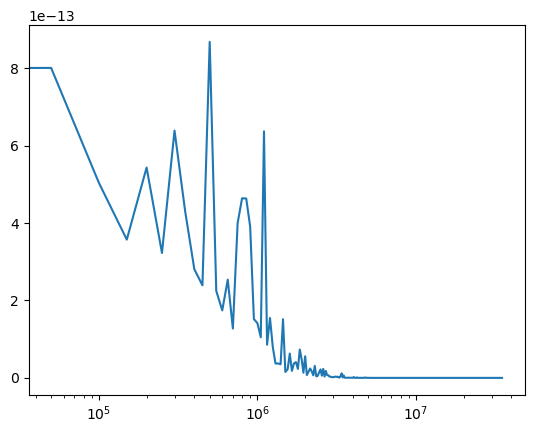

In [121]:
plt.plot(ener, gam_spec[1730])
plt.xscale('log')

print(time[1730]/const.day)
